# Processing, Modeling and Forecasts

#### This notebook goes through the proces by which I imported data, munged, cleaned, explored, and modeled the data. For more insights onto the steps and the reasoning behind choices please refer to the readme.md on https://github.com/jeevooo/spikeout

## Import Libraries

In [1]:
import os, glob
import io
import csv
import requests
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import psycopg2
import math
import seaborn as sns
import pyflux as pf
import peakutils
import warnings
from pandas import datetime, DataFrame
from datetime import timedelta
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from numpy import log
from pandas.plotting import autocorrelation_plot, lag_plot
from peakutils.plot import plot as pplot
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA

Using TensorFlow backend.


## Pull and munge data from analytics.usa.gov/

In [7]:
url = 'http://analytics.usa.gov/data/live/all-pages-realtime.csv' # url to download from analytics.usa.gov

#download webtraffic
csv = requests.get(url).content #download desired .csv from site.
datetimestamp = str(dt.datetime.now()) #get date time stamp of download.
data = pd.read_csv(io.StringIO(csv.decode('utf-8'))) #convert downloaded url (python string) to a .csv.
#data.to_sql('traffic_data_table', engine, if_exists='replace')

#Maniuplate Data
data[data.page.isin(['weather.gov/', 'ssa.gov/', 'usps.com/', 'irs.gov/', 'usajobs.gov/', 'medicare.gov/', 'nasa.gov/', 'va.gov/', 'defense.gov/', 'cdc.gov/'])]
data = data.set_index('page').T
data['Time'] = datetimestamp
data = data.drop('page_title')
col = data.columns.tolist()
col = col[-1:] + col[:-1]
data = data[col]
    
#Export Data
data.to_csv('govtraffic' + datetimestamp + '.csv')

## Additional Munging and saving to PSQL db

In [2]:
# Get all pathnames with .csv from saved files. 
path = r'/Users/JeevKiriella/Documents/Insight/DataSets/Data/' # use your path 
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

# Join each file that's called in
df_from_each_file = (pd.read_csv(f) for f in all_files)
concatenated_df   = pd.concat(df_from_each_file, ignore_index=True) #
concatenated_df = concatenated_df.drop(['Unnamed: 0'], axis=1) #remove unecessary column

# Remove seconds and limit timestamp to minutes. 
concatenated_df["Time"] = concatenated_df["Time"].astype("datetime64[ns]")
concatenated_df['Time'] =  pd.to_datetime(concatenated_df['Time'], format = '%Y-%m-%d %H:%M:S.%f')
concatenated_df['Time'] = concatenated_df['Time'].values.astype('<M8[m]')

# adjust time values for server offset; specific to my sampling
t = '2018-01-19'
t_df = pd.to_datetime (t)
concatenated_df['Time'] = np.where(concatenated_df['Time'] >= t_df, concatenated_df['Time'] - pd.DateOffset(hours = 5), concatenated_df['Time'])

# export new dataframe to .csv
#concatenated_df.to_csv('govtraffic' + '.csv')

# Use Sqlalchemy to connect to database
#dbname = 'spikeout'
#username = 'JeevKiriella'
#engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
#print(engine.url)

# insert data into database from Python
#concatenated_df.to_sql('webster', engine, if_exists='append')concatenated_df.head()

## Get a view of the data

In [3]:
concatenated_df.head(10)

,Time,cdc.gov/,defense.gov/,irs.gov/,medicare.gov/,nasa.gov/,ssa.gov/,usajobs.gov/,usps.com/,va.gov/,weather.gov/
0,2018-01-18 17:10:00,114,643,841,188,177,577,299,1680,569,980
1,2018-01-18 17:15:00,105,605,794,189,146,545,284,1699,529,1022
2,2018-01-18 17:20:00,104,612,778,172,144,545,301,1698,536,1017
3,2018-01-18 17:25:00,86,563,789,192,137,584,263,1658,541,1016
4,2018-01-18 17:31:00,108,546,775,219,151,569,254,1654,525,986
5,2018-01-18 17:32:00,108,546,775,219,151,569,254,1654,525,986
6,2018-01-18 17:36:00,87,478,816,213,136,591,253,1548,474,932
7,2018-01-18 17:37:00,87,478,816,213,136,591,253,1548,474,932
8,2018-01-18 17:42:00,91,485,780,180,141,558,269,1649,426,907
9,2018-01-18 17:47:00,93,447,785,175,153,527,245,1506,414,932


In [4]:
concatenated_df.tail(10)

,Time,cdc.gov/,defense.gov/,irs.gov/,medicare.gov/,nasa.gov/,ssa.gov/,usajobs.gov/,usps.com/,va.gov/,weather.gov/
4097,2018-02-02 10:10:00,98,992,1538,214,251,596,310,1718,913,1240
4098,2018-02-02 10:15:00,154,1001,1590,223,209,642,320,1682,871,1262
4099,2018-02-02 10:20:00,133,944,1702,235,274,690,308,1622,848,1241
4100,2018-02-02 10:25:00,152,993,1617,204,242,649,314,1707,881,1252
4101,2018-02-02 10:30:00,128,962,1619,223,241,659,309,1717,895,1276
4102,2018-02-02 10:35:00,130,1010,1610,209,271,630,260,1747,892,1215
4103,2018-02-02 10:40:00,148,970,1700,202,231,639,290,1772,807,1241
4104,2018-02-02 10:45:00,135,1012,1622,240,234,702,315,1766,840,1192
4105,2018-02-02 10:50:00,144,1043,1615,219,279,714,314,1777,896,1113
4106,2018-02-02 10:55:00,152,952,1708,229,253,690,300,1814,929,1284


# Data Exploration

## 1. Evaluate that sampling is consistent

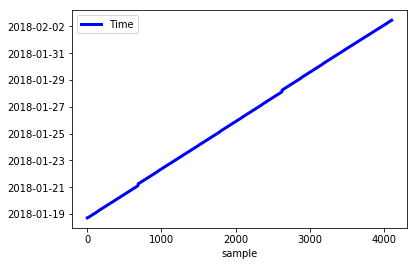

,Time,cdc.gov/,defense.gov/,irs.gov/,medicare.gov/,nasa.gov/,ssa.gov/,usajobs.gov/,usps.com/,va.gov/,weather.gov/,sample
0,2018-01-18 17:10:00,114,643,841,188,177,577,299,1680,569,980,0
1,2018-01-18 17:15:00,105,605,794,189,146,545,284,1699,529,1022,1
2,2018-01-18 17:20:00,104,612,778,172,144,545,301,1698,536,1017,2
3,2018-01-18 17:25:00,86,563,789,192,137,584,263,1658,541,1016,3
4,2018-01-18 17:31:00,108,546,775,219,151,569,254,1654,525,986,4
5,2018-01-18 17:32:00,108,546,775,219,151,569,254,1654,525,986,5
6,2018-01-18 17:36:00,87,478,816,213,136,591,253,1548,474,932,6
7,2018-01-18 17:37:00,87,478,816,213,136,591,253,1548,474,932,7
8,2018-01-18 17:42:00,91,485,780,180,141,558,269,1649,426,907,8
9,2018-01-18 17:47:00,93,447,785,175,153,527,245,1506,414,932,9


In [5]:
concatenated_df['sample'] = concatenated_df.index # create a column called "sample" in order to plot the "Time" on y-axis
concatenated_df.plot(x='sample', y='Time', linewidth = 3, color = 'blue')
plt.show()
concatenated_df.head(10)

### Aggregate data

In [6]:
# aggregate data based on hour to get consistent sampling rate. 
agg_df = concatenated_df.set_index('Time')
agg_df = agg_df.resample("H").sum()

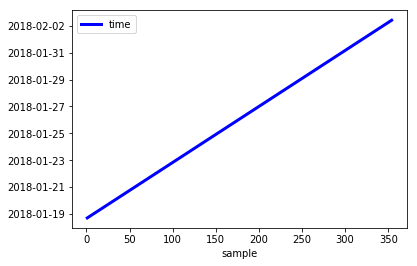

,cdc.gov/,defense.gov/,irs.gov/,medicare.gov/,nasa.gov/,ssa.gov/,usajobs.gov/,usps.com/,va.gov/,weather.gov/,sample,time
Time,,,,,,,,,,,,
2018-02-02 06:00:00,354,2371,4430,280,1644,1266,945,2591,1407,8132,350,2018-02-02 06:00:00
2018-02-02 07:00:00,466,5152,6988,558,1847,2208,1648,5078,4396,11495,351,2018-02-02 07:00:00
2018-02-02 08:00:00,962,8678,11851,1210,2233,3722,2497,10749,8786,14249,352,2018-02-02 08:00:00
2018-02-02 09:00:00,1447,11013,17164,2129,2624,5775,3237,16516,10268,15398,353,2018-02-02 09:00:00
2018-02-02 10:00:00,1636,11821,19383,2629,2903,7766,3593,20553,10507,14884,354,2018-02-02 10:00:00


In [7]:
agg_df['time'] = agg_df.index
agg_df['sample'] = range(1, len(agg_df) + 1)
#plt.plot(agg_df['row'], agg_df['time'])
agg_df.plot(x='sample', y='time', linewidth = 3, color = 'blue')
plt.show()
agg_df.tail()

In [8]:
agg_df.describe()

,cdc.gov/,defense.gov/,irs.gov/,medicare.gov/,nasa.gov/,ssa.gov/,usajobs.gov/,usps.com/,va.gov/,weather.gov/,sample
count,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000
mean,865.785311,4401.850282,8140.700565,1211.567797,2213.562147,3987.155367,2182.516949,10642.675141,3823.177966,8969.025424,177.500000
std,578.051390,4647.698480,6349.878832,1061.175946,2669.283793,2973.346515,1291.725620,9170.384621,4014.837601,4773.574807,102.335233
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,400.250000,671.000000,2831.500000,317.250000,1266.500000,1593.000000,1019.500000,2981.500000,913.500000,4679.750000,89.250000
50%,663.000000,2039.000000,6427.500000,817.500000,1646.500000,3218.000000,1952.000000,6947.000000,1428.500000,9411.000000,177.500000
75%,1195.500000,8645.000000,12739.750000,2083.000000,2547.000000,5982.750000,3206.500000,18243.000000,8596.750000,12416.500000,265.750000
max,2426.000000,14503.000000,23360.000000,3508.000000,34490.000000,12801.000000,4606.000000,42805.000000,11903.000000,21062.000000,354.000000


## Plot aggregated data

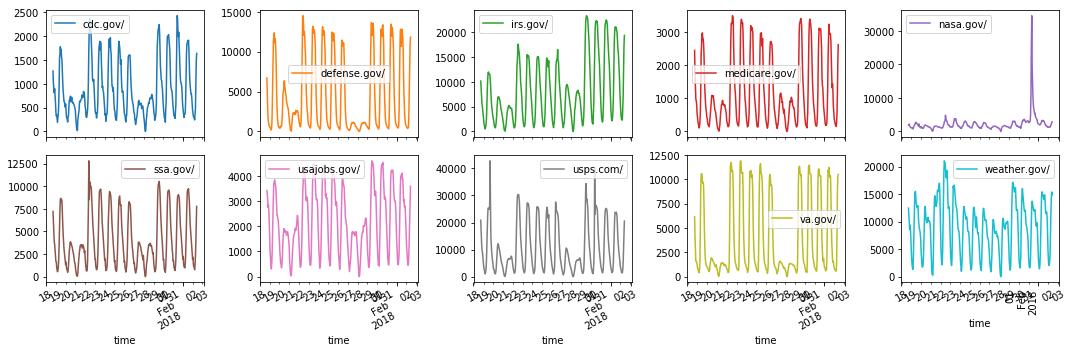

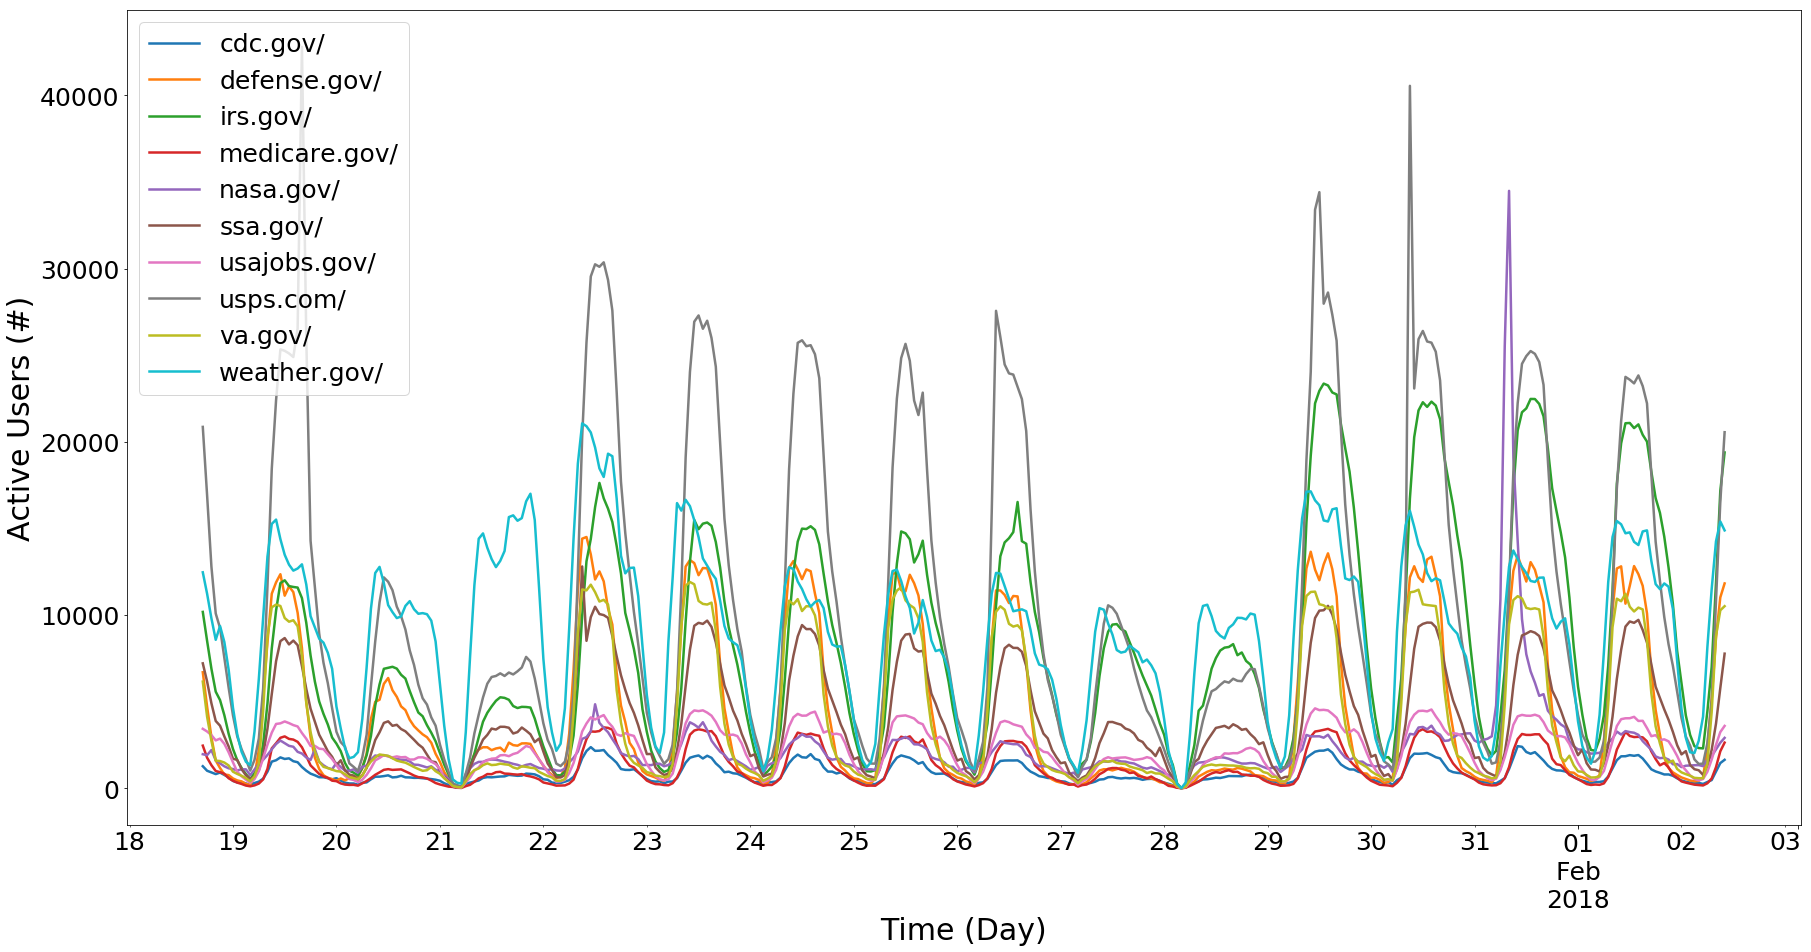

In [10]:
# subplots
cols2select = [col for col in agg_df.columns.tolist() if col not in ['sample']] # do not plot 'sample', create a list of columns to plot.
agg_df[cols2select].plot(x = 'time', subplots = True, grid = False, layout = (2,5), sharex = True, sharey = False, legend = True, figsize = (15,5))
plt.xticks(rotation=90)
plt.tight_layout()

# combined plot
ax = agg_df[cols2select].plot(x = 'time', figsize = (30,15), fontsize = 25, linewidth=2.5, legend=False)
ax.set_xlabel("Time (Day)", fontsize = 30)
ax.set_ylabel("Active Users (#)", fontsize = 30)
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='best', fontsize = 25)
plt.show()

## 2 . Assess data structure

### Lag Plots

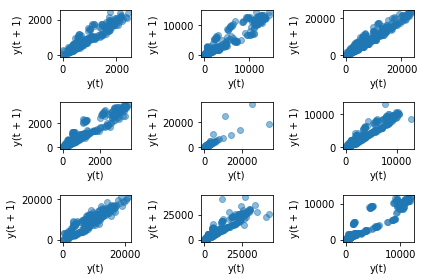

In [13]:
# a loop to plot the different time series plots 
subplots = [(331,'cdc.gov/'), (332,'defense.gov/'), (333, 'irs.gov/'), (334, 'medicare.gov/'), (335, 'nasa.gov/'), (336, 'ssa.gov/'), (337, 'weather.gov/'), (338, 'usps.com/'), (339, 'va.gov/')]

for subplot in subplots:
    plt.subplot(subplot[0])
    lag_plot(agg_df[subplot[1]], alpha=0.5)

plt.tight_layout()
plt.show()

### Autocorrelation Plots

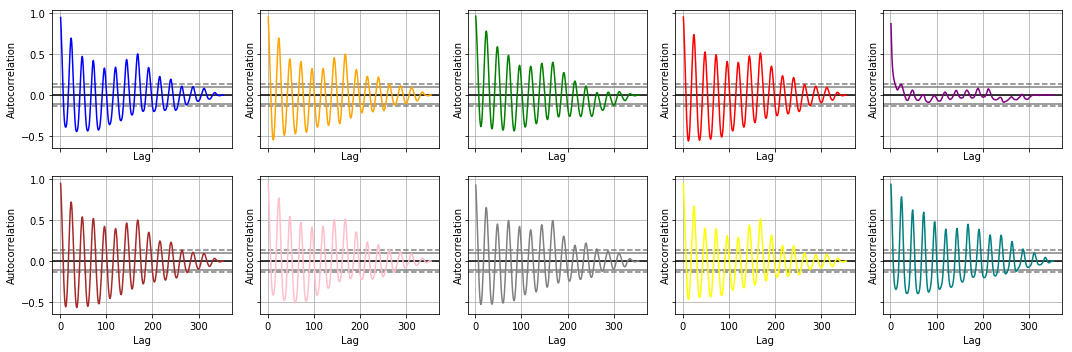

In [33]:
#subplots = [(331,'cdc.gov/'), (332,'defense.gov/'), (333, 'irs.gov/'), (334, 'medicare.gov/'), (335, 'nasa.gov/'), (336, 'ssa.gov/'), (337, 'weather.gov/'), (338, 'usps.com/'), (339, 'va.gov/')]
#for subplot in subplots:
#    plt.subplot(subplot[0])
#    autocorrelation_plot(agg_df[subplot[1]])
#plt.show()
#plt.tight_layout()


#fig, ax = plt.subplots(3, 3, figsize=(16,10))
#[ax + (url,) for ax, url in zip(axes, subplots)]
#for ax, url in zip(axes, subplots):
#    autocorrelation_plot(agg_df[url], ax = ax)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15,5), sharex = True, sharey = True)

autocorrelation_plot(agg_df['cdc.gov/'], ax = axes[0,0], color = 'blue')
autocorrelation_plot(agg_df['defense.gov/'], ax = axes[0,1], color = 'orange')
autocorrelation_plot(agg_df['irs.gov/'], ax = axes[0,2], color = 'green')
autocorrelation_plot(agg_df['medicare.gov/'], ax = axes[0,3], color = 'red')
autocorrelation_plot(agg_df['nasa.gov/'], ax = axes[0,4], color = 'purple')
autocorrelation_plot(agg_df['ssa.gov/'], ax = axes[1,0], color = 'brown')
autocorrelation_plot(agg_df['usajobs.gov/'], ax = axes[1,1], color = 'pink')
autocorrelation_plot(agg_df['usps.com/'], ax = axes[1,2], color = 'grey')
autocorrelation_plot(agg_df['va.gov/'], ax = axes[1,3], color = 'yellow')
autocorrelation_plot(agg_df['weather.gov/'], ax = axes[1,4], color = 'teal')
plt.tight_layout()
plt.show()

## Focus on the usps.com/ data for example analysis

### Get prelimiary stats and rolling mean & std for usps.com/

In [34]:
#create a new df for usps.com/
uspsdf = agg_df.filter(['usps.com/'], axis = 1) #create a df for usps time series. 
uspsdf.rename(columns={'usps.com/': 'usps'}, inplace = True) # rename the column name from 'usps.com/' to 'usps'

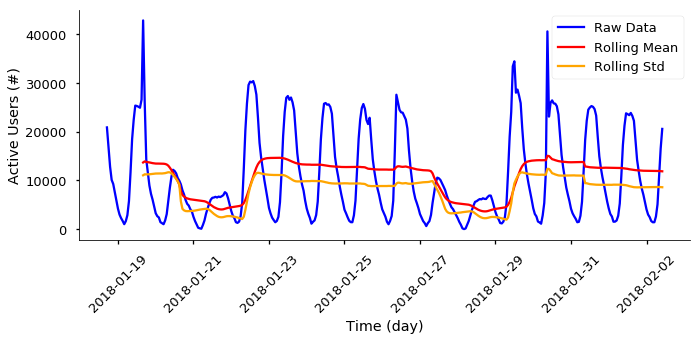

In [35]:
win = 24 #set to 24 for daily seasonality (because data is grouped by the hour)
rollMean = uspsdf.usps.rolling(window=win, center=False).mean() #calutlate sliding mean using pandas "rolling" function.
rollStd = uspsdf.usps.rolling(window=win, center=False).std() #calutlate sliding std using pandas "rolling" function.

# plot the raw data with rolling mean and standard deviation
sns.set_context('talk')
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(uspsdf.usps, label = 'Raw Data', color = 'blue')
ax.plot(rollMean, label = 'Rolling Mean', color = 'red')
ax.plot(rollStd, label = 'Rolling Std', color = 'orange')
ax.set_ylabel('Active Users (#)')
ax.set_xlabel('Time (day)')
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
sns.despine()

In [36]:
uspsdf.describe()

,usps
count,354.000000
mean,10642.675141
std,9170.384621
min,0.000000
25%,2981.500000
50%,6947.000000
75%,18243.000000
max,42805.000000


In [38]:
## remove zero in data. **Note glob is not pulling all data from db causing the 0 min.**
## explored making it a zero and explored replacing with mean but the latter adds artifact to the signal.
## approach here is to replace with previous value

min = uspsdf.nsmallest(2, 'usps')
#min = min.iloc[1,:] #pull second smallest value

#mask = uspsdf.usps==0 # mask creates a bootlean list (i.e., True or False based on condition)
#uspsdf = uspsdf[~mask] # this would be if you want to delete all rows that are false
#uspsdf.usps[mask] = uspsdf['usps'].mean() #replace rows with the mean.

uspsdf[uspsdf.usps == 0] = 74 #74 is the previous value and also the lowest value.
uspsdf.describe()

,usps
count,354.000000
mean,10642.884181
std,9170.142173
min,74.000000
25%,2981.500000
50%,6947.000000
75%,18243.000000
max,42805.000000


# Set up data for training

In [42]:
#Clipping the data between two spikes to avoid the use of spikes in modeling and training. 
usps_train = uspsdf[30:252]

#Use adjacent test set with spike for prediction.
usps_test = uspsdf[253:299]

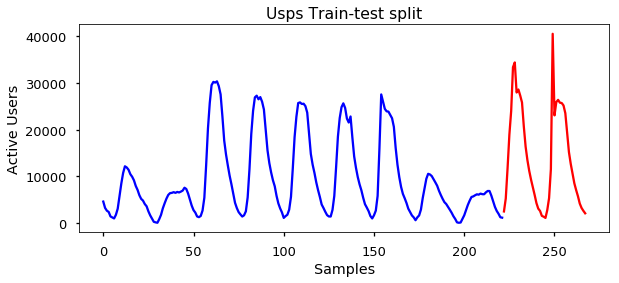

In [59]:
#plot of the training and testing set. 
usps_train_plt = usps_train.values
usps_test_plt = usps_test.values
plt.figure(1,  figsize=(9.5,13))
index = 1
plt.subplot(310 + index)
plt.plot(usps_train_plt, color = 'blue')
plt.plot([None for i in usps_train_plt] + [x for x in usps_test_plt], color = 'red')
plt.title('Usps Train-test split')
plt.xlabel('Samples')
plt.ylabel('Active Users')
plt.show()

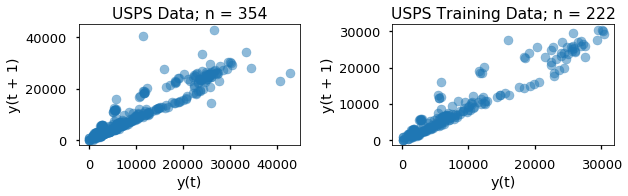

In [62]:
fig, axs = plt.subplots(1,2,figsize=(9,3))
plt.subplot(121)
plt.title('USPS Data; n = 354')
lag_plot(uspsdf, alpha=0.5)
plt.subplot(122)
plt.title('USPS Training Data; n = 222')
lag_plot(usps_train, alpha=0.5)
plt.tight_layout()
plt.show()

**Observing the lagplots of both datasets we can observe that the data is autoregressive.**

## Static Threshold - determine peaks of training data

index: [  63.28506787   85.38461538  109.49321267  133.60180995  154.69683258] peak: [ 29462.6400208   26129.10330937  24591.52670376  24468.92828186
  26599.95678898]


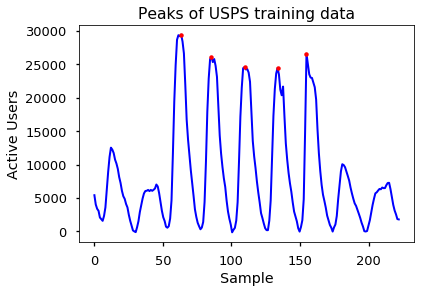

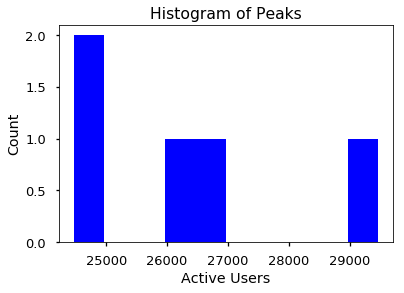

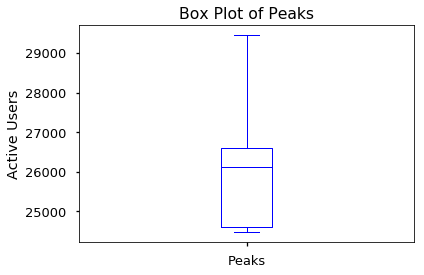

In [67]:
# replace peaks with typical peak (i.e., clip peak) so that don't lose samples.
#clip = 31000 #set the value of clip

#a = np.array(uspsdf['usps'].values.tolist())
#uspsdf['usps'] = np.where(a > clip, clip, a).tolist()
#uspsdf.plot(figsize = (10,6))

#Threshold for peak detection in peakutils
thres = 0.50
min_dist = 20

data = usps_train.values
baseline_values = peakutils.baseline(data)
data_without_baseline = data - baseline_values
data_without_baseline = data_without_baseline.flatten()
peakind = peakutils.indexes(data_without_baseline, thres=thres, min_dist=min_dist)

#print(x[peakind], data_without_baseline[peakind])
n = len(usps_train)
x = np.linspace(0, len(data_without_baseline), n)
print('index:', x[peakind], 'peak:', data_without_baseline[peakind])
#plt.figure(figsize=(10,6))
#pplot(x, data_without_baseline, peakind)
plt.plot(x, data_without_baseline, lw = 2, color = 'blue')
plt.plot(x[peakind],data_without_baseline[peakind], marker = "o", color = 'red', ls = "", ms = 4.5)
plt.title('Peaks of USPS training data')
plt.xlabel('Sample')
plt.ylabel ('Active Users')
plt.show()

# convert the y values to dataframe
peaky = data_without_baseline[peakind] #create an array with peak Y-values
peaky_df = pd.DataFrame(peaky, columns = ['Peaks']) # create a df of peal Y-values
peaky_df.hist(grid = False, color = 'blue') # Plot a histogram of the values
plt.title('Histogram of Peaks')
plt.xlabel ('Active Users')
plt.ylabel ('Count')
plt.show()

peaky_df.plot.box(color = 'blue')
plt.title('Box Plot of Peaks')
plt.ylabel ('Active Users')
plt.show()

### Media of peaks

The data is skewed therefore I took the median and 75th quartile

In [72]:
# obtain stats of peaks
t = peaky_df.mean() + (3*peaky_df.std()) #threshold of 3SD above the mean. 
quant_ninety = peaky_df.quantile(0.90) #threshold of 90th percentile
print('mean + 2SD:', t)
print('90% Quantile:', quant_ninety)

peaky_df.describe().T

mean + 2SD: Peaks    32321.428013
dtype: float64
90% Quantile: Peaks    28317.566728
Name: 0.9, dtype: float64


,count,mean,std,min,25%,50%,75%,max
Peaks,5.0,26250.431021,2023.665664,24468.928282,24591.526704,26129.103309,26599.956789,29462.640021


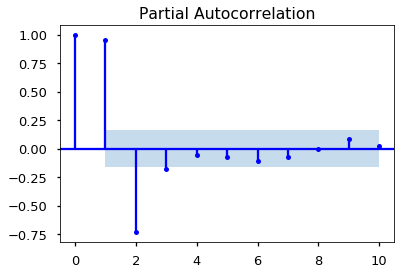

In [430]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(usps_model, lags = 10, color = 'blue')
plt.show()

# Modeling and Prediction Methods

## ARIMA

### Why an ARIMA?

I chose an ARIMA here because of the inherent structure in the data exhibited by the lag-lag plot. That plot demonstrates an AR process at lag 1. Therefore an ARIMA can take into account this feature of the data. 

### Features of ARIMA based on several measures. 
1. AR (p) - Partial autocorrelation function. 
2. I (q) - Dickey-Fullter test. 
3. MA (d) - Autocorrelation function.

#### 1. Partial Autocorrelation Plot

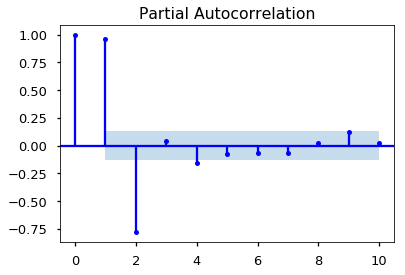

In [85]:
plot_pacf(usps_train, lags = 10, color = 'blue')
plt.show()

**We find the point at which the blue line crosses the shaded region to determine the AR value of the model. In this case we select at AR(2).**

#### 2. Dickey-Fuller Test

In [82]:
from statsmodels.tsa.stattools import adfuller
usps_train_AD = usps_train.values
result = adfuller(usps_train_AD)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ValueError: too many values to unpack (expected 2)

**The AD test suggests the data is stationary and no differencing is necessary for modeling the data.**

#### 3. Autocorrelation Plot

Text(0.5,1,'Usps Training Set Autocorrelation Clipped at 10')

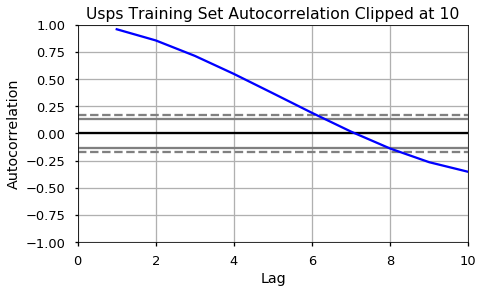

In [81]:
plt.figure(figsize = (7,4))
ax = autocorrelation_plot(usps_train, color = 'blue')
ax.set_xlim(0,10)
plt.title('Usps Training Set Autocorrelation Clipped at 10')

**We find the point at which the blue line crosses the dashed line to determine the MA value of the model. In this case we select MA(6).**

### ARIMA in Statsmodels

### ARIMA in Pyflux

Normal ARIMA(2,0,6)                                                                                       
======================================================= ==================================================
Dependent Variable: usps                                Method: MLE                                       
Start Date: 2018-01-20 05:00:00                         Log Likelihood: -1960.6158                        
End Date: 2018-01-29 04:00:00                           AIC: 3941.2316                                    
Number of observations: 216                             BIC: 3974.9844                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 9238.6046  647.7737   14.2621  0.0      (7968.9682 | 10508.241)  
AR(1)                                

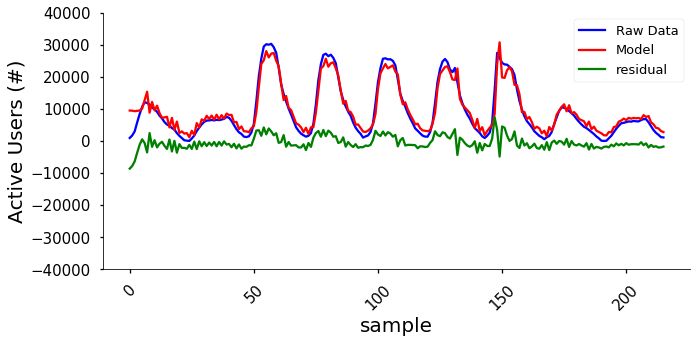

In [88]:
#train, test = usps[0:90], usps[91:178]
#train, test = usps[0:178], usps[178:266]
#train, test = usps[0:266], usps[266:354]

p = 2
q = 0
d = 6

model = pf.ARIMA(data=usps_train, ar = p, integ = q, ma = d, target = 'usps', family=pf.Normal())
fit = model.fit('MLE')
mu, y = model._model(model.latent_variables.get_z_values())
yhat = model.link(mu)
fit.summary()

y = pd.DataFrame(y)
yhat = pd.DataFrame(yhat)
residual = y - yhat

result = pd.concat([y,yhat], axis = 1)

sns.set_context('talk')
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(y, label = 'Raw Data', color = 'blue')
ax.plot(yhat, label = 'Model', color = 'red')
ax.plot(residual, label = 'residual', color = 'green')
ax.set_ylabel('Active Users (#)', fontsize = 20)
ax.set_xlabel('Sample', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)
plt.yticks(fontsize = 15)
ax.legend()
plt.tight_layout()
#ymin, ymax = ylim()   # return the current ylim
ax.set_ylim([-40000, 40000])  # set the ylim to ymin, ymax
sns.despine()

#test_clip = test[0:24]
#test_clip = test_clip['usps']
#p_test = p['usps']
#error = mean_squared_error(test_clip, p_test)
#print('Test MSE: %.3f' % error)

In [547]:
#RMSE
rmseARIMA = ((y - yhat) ** 2).mean() ** .5
rmseARIMA.astype(float)
#print("RMSE of ARIMA (%p, %q, %d)" %(p, q, d))
print('RMSE of ARIMA:', rmseARIMA)

RMSE of ARIMA: 0    2466.009797
dtype: float64


In [414]:
model.plot_predict(h=24,past_values=143,figsize=(7,5))

In [760]:
#modelARIMA.plot_predict(h=24,past_values=324,figsize=(7,5))
p = model.predict(24, intervals=True)
p.head()

,usps,1% Prediction Interval,5% Prediction Interval,95% Prediction Interval,99% Prediction Interval
Time,,,,,
2254-08-19 05:00:00,3610.910332,-2061.147028,-415.486081,7701.142728,9455.166060
2254-08-19 06:00:00,7853.510243,144.752156,2408.597552,13325.424381,15544.647533
2254-08-19 07:00:00,12068.532596,4270.989075,6553.675603,17632.383780,19951.269323
2254-08-19 08:00:00,14986.483795,7163.934398,9391.814620,20632.354010,22843.794557
2254-08-19 09:00:00,16247.418862,8179.579015,10429.903423,21943.990582,24278.043703


In [620]:
usps_val = usps_model['usps']
y_errorlow = p.iloc[:, 2]
y_errorhigh = p['95% Prediction Interval']

In [621]:
val = pd.concat([y,yhat], axis = 1)

In [753]:
# set up variables for plot
pred = p['usps']
pred = pred.reset_index()
pred = pred['usps']
usps_test = usps_test.reset_index()
usps_test = usps_test['usps']
pred.head()

pred_residual = usps_test - pred

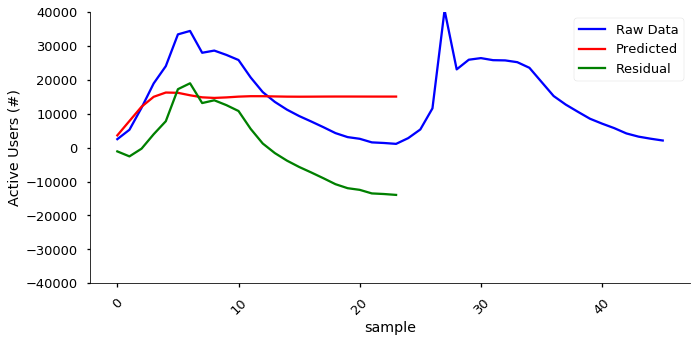

In [754]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(usps_test, label = 'Raw Data', color = 'blue')
ax.plot(pred, label = 'Predicted', color = 'red')
ax.plot(pred_residual, label = 'Residual', color = 'green')
ax.set_ylabel('Active Users (#)')
ax.set_xlabel('sample')
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
ax.set_ylim([-40000, 40000])  # set the ylim to ymin, ymax
sns.despine()

#### ARIMA Model Validation - Multiple train test splits

In [355]:
X = uspsdf.astype(float).values #need to convert series to numpy array.
splits = TimeSeriesSplit(n_splits=3)

index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))

Observations: 178
Training Observations: 90
Testing Observations: 88
Observations: 266
Training Observations: 178
Testing Observations: 88
Observations: 354
Training Observations: 266
Testing Observations: 88


In [543]:
#variables for cross-validation
signal = uspsdf[30:277]
signal = signal['usps']
N = len(signal)*0.7
model

In [552]:
N = 172

In [640]:
# loops over data for range of paramters
#def garch_model_fitting(signal,target,N):  
#    for p in range(1,3):
#        for q in range(1,3):
#            if(p == 1 and q == 1):
#                garch_mod_B = pf.GARCH(data=signal[signal.index[0]:signal.index[N]],p=1,q=1,target=target)
#                x = garch_mod_B.fit()
#                aic_B = x.aic
#            else:
#                garch_mod = pf.GARCH(data=signal[signal.index[0]:signal.index[N]],p=p,q=q,target=target)
#                x = garch_mod.fit()
#                aic = x.aic
#                if(aic < aic_B):
#                    garch_mod_B = garch_mod
#                    aic_B = aic
#
#    return garch_mod_B 

def model_predicting(model, signal, N, nxt = 5):
    print('prediciting is starting')
    lastindx = signal.shape[0]
    test_data = signal[signal.index[N]:signal.index[lastindx-1]]
    rows = len(test_data)-(nxt)
    predicted_values =  np.zeros([rows,nxt])
    real_values =  np.zeros([rows,nxt])

    s = N+1
    for i in range(len(test_data)-(nxt)):
        real_values[i] = signal[signal.index[s+i]:signal.index[s+i+nxt-1]]
        
    predicted = model.predict(nxt).values#model.predict(start,end,dynamic=True)

    predicted_values[0,:] = predicted[0:nxt].reshape([nxt])
    n = model.data.shape[0]
    for i in range(len(test_data)-(nxt)-1):
        print('i:', i)
        for j in range(2,n):
            print('j:', j)
            model.data[j-1] = model.data[j]
#        model.data.append(signal[signal.index[n+i]])
#model.data[n-1] = signal[signal.index[n+i]]
        np.concatenate(model.data, signal[signal.index[n+i]])
        predicted = model.predict(nxt).values
        predicted_values[i+1,:] = predicted[0:nxt].reshape([nxt])

    return real_values, predicted_values

model_predicting(model, signal, N, nxt = 5)

prediciting is starting
i: 0
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
j: 14
j: 15
j: 16
j: 17
j: 18
j: 19
j: 20
j: 21
j: 22
j: 23
j: 24
j: 25
j: 26
j: 27
j: 28
j: 29
j: 30
j: 31
j: 32
j: 33
j: 34
j: 35
j: 36
j: 37
j: 38
j: 39
j: 40
j: 41
j: 42
j: 43
j: 44
j: 45
j: 46
j: 47
j: 48
j: 49
j: 50
j: 51
j: 52
j: 53
j: 54
j: 55
j: 56
j: 57
j: 58
j: 59
j: 60
j: 61
j: 62
j: 63
j: 64
j: 65
j: 66
j: 67
j: 68
j: 69
j: 70
j: 71
j: 72
j: 73
j: 74
j: 75
j: 76
j: 77
j: 78
j: 79
j: 80
j: 81
j: 82
j: 83
j: 84
j: 85
j: 86
j: 87
j: 88
j: 89
j: 90
j: 91
j: 92
j: 93
j: 94
j: 95
j: 96
j: 97
j: 98
j: 99
j: 100
j: 101
j: 102
j: 103
j: 104
j: 105
j: 106
j: 107
j: 108
j: 109
j: 110
j: 111
j: 112
j: 113
j: 114
j: 115
j: 116
j: 117
j: 118
j: 119
j: 120
j: 121
j: 122
j: 123
j: 124
j: 125
j: 126
j: 127
j: 128
j: 129
j: 130
j: 131
j: 132
j: 133
j: 134
j: 135
j: 136
j: 137
j: 138
j: 139
j: 140
j: 141
j: 142
j: 143
j: 144
j: 145
j: 146
j: 147
j: 148
j: 149
j: 150
j: 151
j: 152
j: 153
j: 154
j: 155

j: 57
j: 58
j: 59
j: 60
j: 61
j: 62
j: 63
j: 64
j: 65
j: 66
j: 67
j: 68
j: 69
j: 70
j: 71
j: 72
j: 73
j: 74
j: 75
j: 76
j: 77
j: 78
j: 79
j: 80
j: 81
j: 82
j: 83
j: 84
j: 85
j: 86
j: 87
j: 88
j: 89
j: 90
j: 91
j: 92
j: 93
j: 94
j: 95
j: 96
j: 97
j: 98
j: 99
j: 100
j: 101
j: 102
j: 103
j: 104
j: 105
j: 106
j: 107
j: 108
j: 109
j: 110
j: 111
j: 112
j: 113
j: 114
j: 115
j: 116
j: 117
j: 118
j: 119
j: 120
j: 121
j: 122
j: 123
j: 124
j: 125
j: 126
j: 127
j: 128
j: 129
j: 130
j: 131
j: 132
j: 133
j: 134
j: 135
j: 136
j: 137
j: 138
j: 139
j: 140
j: 141
j: 142
j: 143
j: 144
j: 145
j: 146
j: 147
j: 148
j: 149
j: 150
j: 151
j: 152
j: 153
j: 154
j: 155
j: 156
j: 157
j: 158
j: 159
j: 160
j: 161
j: 162
j: 163
j: 164
j: 165
j: 166
j: 167
j: 168
j: 169
j: 170
j: 171
j: 172
j: 173
j: 174
j: 175
j: 176
j: 177
j: 178
j: 179
j: 180
j: 181
j: 182
j: 183
j: 184
j: 185
j: 186
j: 187
j: 188
j: 189
j: 190
j: 191
j: 192
j: 193
j: 194
j: 195
j: 196
j: 197
j: 198
j: 199
j: 200
j: 201
j: 202
j: 203
j: 204
j: 205


j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
j: 14
j: 15
j: 16
j: 17
j: 18
j: 19
j: 20
j: 21
j: 22
j: 23
j: 24
j: 25
j: 26
j: 27
j: 28
j: 29
j: 30
j: 31
j: 32
j: 33
j: 34
j: 35
j: 36
j: 37
j: 38
j: 39
j: 40
j: 41
j: 42
j: 43
j: 44
j: 45
j: 46
j: 47
j: 48
j: 49
j: 50
j: 51
j: 52
j: 53
j: 54
j: 55
j: 56
j: 57
j: 58
j: 59
j: 60
j: 61
j: 62
j: 63
j: 64
j: 65
j: 66
j: 67
j: 68
j: 69
j: 70
j: 71
j: 72
j: 73
j: 74
j: 75
j: 76
j: 77
j: 78
j: 79
j: 80
j: 81
j: 82
j: 83
j: 84
j: 85
j: 86
j: 87
j: 88
j: 89
j: 90
j: 91
j: 92
j: 93
j: 94
j: 95
j: 96
j: 97
j: 98
j: 99
j: 100
j: 101
j: 102
j: 103
j: 104
j: 105
j: 106
j: 107
j: 108
j: 109
j: 110
j: 111
j: 112
j: 113
j: 114
j: 115
j: 116
j: 117
j: 118
j: 119
j: 120
j: 121
j: 122
j: 123
j: 124
j: 125
j: 126
j: 127
j: 128
j: 129
j: 130
j: 131
j: 132
j: 133
j: 134
j: 135
j: 136
j: 137
j: 138
j: 139
j: 140
j: 141
j: 142
j: 143
j: 144
j: 145
j: 146
j: 147
j: 148
j: 149
j: 150
j: 151
j: 152
j: 153
j: 154
j: 155
j: 156
j: 157
j: 158
j: 159
j: 160
j: 161
j: 162
j: 163
j:

j: 180
j: 181
j: 182
j: 183
j: 184
j: 185
j: 186
j: 187
j: 188
j: 189
j: 190
j: 191
j: 192
j: 193
j: 194
j: 195
j: 196
j: 197
j: 198
j: 199
j: 200
j: 201
j: 202
j: 203
j: 204
j: 205
j: 206
j: 207
j: 208
j: 209
j: 210
j: 211
j: 212
j: 213
j: 214
j: 215
j: 216
j: 217
j: 218
j: 219
j: 220
j: 221
i: 20
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
j: 14
j: 15
j: 16
j: 17
j: 18
j: 19
j: 20
j: 21
j: 22
j: 23
j: 24
j: 25
j: 26
j: 27
j: 28
j: 29
j: 30
j: 31
j: 32
j: 33
j: 34
j: 35
j: 36
j: 37
j: 38
j: 39
j: 40
j: 41
j: 42
j: 43
j: 44
j: 45
j: 46
j: 47
j: 48
j: 49
j: 50
j: 51
j: 52
j: 53
j: 54
j: 55
j: 56
j: 57
j: 58
j: 59
j: 60
j: 61
j: 62
j: 63
j: 64
j: 65
j: 66
j: 67
j: 68
j: 69
j: 70
j: 71
j: 72
j: 73
j: 74
j: 75
j: 76
j: 77
j: 78
j: 79
j: 80
j: 81
j: 82
j: 83
j: 84
j: 85
j: 86
j: 87
j: 88
j: 89
j: 90
j: 91
j: 92
j: 93
j: 94
j: 95
j: 96
j: 97
j: 98
j: 99
j: 100
j: 101
j: 102
j: 103
j: 104
j: 105
j: 106
j: 107
j: 108
j: 109
j: 110
j: 111
j: 112
j: 113
j: 114
j: 115
j: 116
j

IndexError: index 247 is out of bounds for axis 0 with size 247

In [637]:
len(signal)

247

In [777]:
#X = usps_model.drop(columns='day')
#X = usps_model.drop(['day2', 'day'])


,usps
Time,
2018-01-18 17:00:00,20860
2018-01-18 18:00:00,16905
2018-01-18 19:00:00,12792
2018-01-18 20:00:00,10086
2018-01-18 21:00:00,9249


Test MSE: 57776642.720


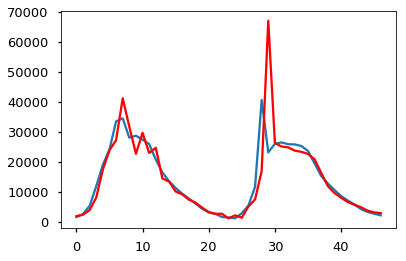

In [802]:
# First Split of Data (178) samples.
from statsmodels.tsa.arima_model import ARIMA
#from pandas import Series
import warnings

X = nn_weather.astype(float).values #need to convert series to numpy array.
#ARIMA(df.astype(float), order=(2,0,1))
#size = int(len(X) * 0.66)
train, test = X[30:252], X[252:299]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(2,0,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
warnings.filterwarnings("ignore") 
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

b = [row[0] for row in predictions]
predictions = pd.DataFrame(b)
#test = pd.DataFrame(predictions)
residual = test - predictions


In [803]:
residual.mean()

0   -36.373322
dtype: float64

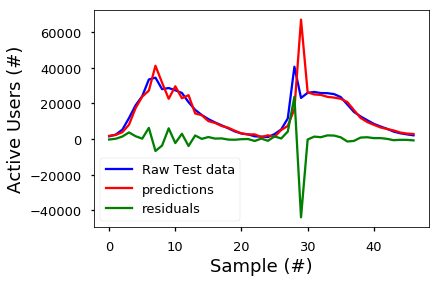

0   -36.373322
dtype: float64

In [804]:
plt.plot(test, label = 'Raw Test data', color = 'blue')
plt.xlabel('Sample (#)', fontsize=18)
plt.ylabel('Active Users (#)', fontsize=18)
plt.plot(predictions, label = 'predictions', color = 'red')
plt.plot(residual, label = 'residuals', color = 'green')
plt.legend(loc = 'best')
plt.show()

residual.mean()

Test MSE: 3388369.559


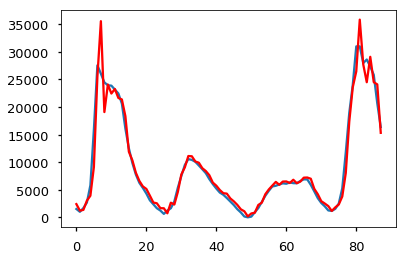

In [282]:
#ARIMA(df.astype(float), order=(2,0,1))
#size = int(len(X) * 0.66)
train, test = X[0:178], X[178:266]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(2,0,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
warnings.filterwarnings("ignore") 
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Test MSE: 11244883.752


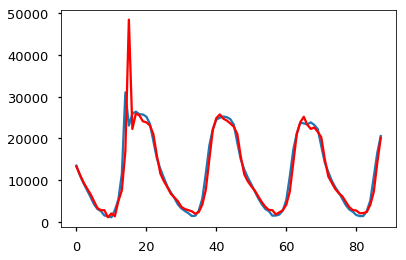

In [283]:
#ARIMA(df.astype(float), order=(2,0,1))
#size = int(len(X) * 0.66)
train, test = X[0:266], X[266:354]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(2,0,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
warnings.filterwarnings("ignore") 
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# ARIMAX

['usps', 'shut_down', 'day']


,usps,shut_down,day
Time,,,
2018-01-18 17:00:00,20860,0.0,1.0
2018-01-18 18:00:00,16905,0.0,1.0
2018-01-18 19:00:00,12792,0.0,1.0
2018-01-18 20:00:00,10086,0.0,1.0
2018-01-18 21:00:00,9249,0.0,1.0


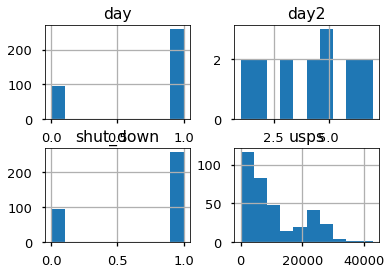

In [873]:
import pyflux as pf
import datetime as dt

#create df
usps2 = uspsdf
#usps2 = agg_df[['time', 'usps.com/']]

#Add features
#usps.index = usps['Time'];

usps2.loc[(usps2.index <= '2018-01-20 00:00:00'), 'shut_down'] = 1;
usps2.loc[(usps2.index >= '2018-01-20 00:00:00'), 'shut_down'] = 0;
usps2.loc[(usps2.index <= '2018-01-22 17:00:00'), 'shut_down'] = 0;
usps2.loc[(usps2.index >= '2018-01-22 17:00:00'), 'shut_down'] = 1;

#df[(df['date'] > '2000-6-1') & (df['date'] <= '2000-6-10')] #exmaple
#(df.loc['2000-6-1':'2000-6-10']) #exmaple

# 1 = weekday; 0 = weekend
usps2.loc[(usps2.index <= '2018-01-20 00:00:00'), 'day'] = 1;
usps2.loc[((usps2.index >= '2018-01-20 00:00:00') & (usps2.index < '2018-01-22 00:00:00'), 'day')] = 0;
usps2.loc[((usps2.index >= '2018-01-22 00:00:00') & (usps2.index < '2018-01-26 00:00:00'), 'day')] = 1;
usps2.loc[((usps2.index >= '2018-01-26 00:00:00') & (usps2.index < '2018-01-28 00:00:00'), 'day')] = 0;
usps2.loc[((usps2.index >= '2018-01-28 00:00:00') & (usps2.index < '2018-02-03 00:00:00'), 'day')] = 1;

# day of the week variable
#usps2.loc[((usps2.index == '2018-01-18'), 'day2')] = 4
#usps2.loc[((usps2.index == '2018-01-19'), 'day2')] = 5
#usps2.loc[((usps2.index == '2018-01-20'), 'day2')] = 6
#usps2.loc[((usps2.index == '2018-01-21'), 'day2')] = 7
#usps2.loc[((usps2.index == '2018-01-22'), 'day2')] = 1
#usps2.loc[((usps2.index == '2018-01-23'), 'day2')] = 2
#usps2.loc[((usps2.index == '2018-01-24'), 'day2')] = 3
#usps2.loc[((usps2.index == '2018-01-25'), 'day2')] = 4
#usps2.loc[((usps2.index == '2018-01-26'), 'day2')] = 5
#usps2.loc[((usps2.index == '2018-01-27'), 'day2')] = 6
#usps2.loc[((usps2.index == '2018-01-28'), 'day2')] = 7
#usps2.loc[((usps2.index == '2018-01-29'), 'day2')] = 1
#usps2.loc[((usps2.index == '2018-01-30'), 'day2')] = 2
#usps2.loc[((usps2.index == '2018-01-31'), 'day2')] = 3
#usps2.loc[((usps2.index == '2018-02-01'), 'day2')] = 4
#usps2.loc[((usps2.index == '2018-02-02'), 'day2')] = 5


#usps2.rename(columns={'usps.com/': 'usps'}, inplace = True)

#Manipulate data
#usps2['nasalognorm'] = np.log(usps2['usps'])
usps2.hist()
usps2 = usps2.drop(columns='day2')
print(usps2.columns.values.tolist())

#usps = usps.resample("H").sum()

usps2.head()

In [439]:
# Is gov shutdown driving traffic?
import statsmodels.api as sm
print(sm.tsa.stattools.grangercausalitytests(usps2[['shut_down','usps']].dropna(),1))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0786  , p=0.0258  , df_denom=139, df_num=1
ssr based chi2 test:   chi2=5.1882  , p=0.0227  , df=1
likelihood ratio test: chi2=5.0957  , p=0.0240  , df=1
parameter F test:         F=5.0786  , p=0.0258  , df_denom=139, df_num=1
{1: ({'ssr_ftest': (5.078617001703261, 0.025787934868362693, 139.0, 1), 'ssr_chi2test': (5.1882274405889426, 0.022740398882637711, 1), 'lrtest': (5.0956939793668425, 0.023985315062741805, 1), 'params_ftest': (5.078617001703142, 0.025787934868364466, 139.0, 1)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1c34441a20>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1c31ef5e80>, array([[ 0.,  1.,  0.]])])}


In [440]:
# is usps driving the shutdown?
import statsmodels.api as sm
print(sm.tsa.stattools.grangercausalitytests(usps2[['usps','shut_down']].dropna(),1))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3173  , p=0.2530  , df_denom=139, df_num=1
ssr based chi2 test:   chi2=1.3458  , p=0.2460  , df=1
likelihood ratio test: chi2=1.3394  , p=0.2471  , df=1
parameter F test:         F=1.3173  , p=0.2530  , df_denom=139, df_num=1
{1: ({'ssr_ftest': (1.3173460685249965, 0.2530404686550376, 139.0, 1), 'ssr_chi2test': (1.3457779980615072, 0.24601757118723291, 1), 'lrtest': (1.3394408286085309, 0.24713260327881142, 1), 'params_ftest': (1.3173460685249871, 0.2530404686550376, 139.0, 1)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1c34441940>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1c31ef54a8>, array([[ 0.,  1.,  0.]])])}


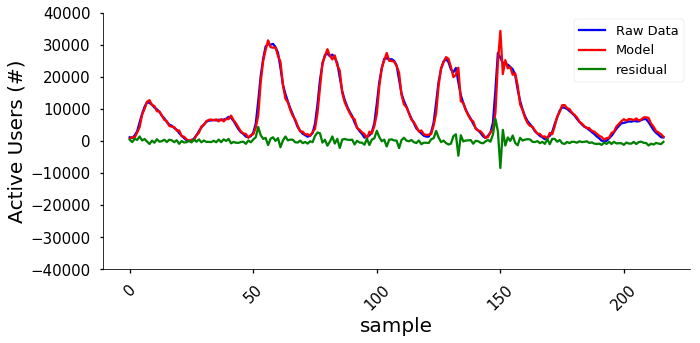

In [809]:
p = 2
q = 0
d = 5 #should be 6 for entire series

model = pf.ARIMAX(data=usps_model, formula='usps~1+shut_down+day', ar = p, integ = q, ma = d, family=pf.Normal())
fit = model.fit('MLE')
mu, y = model._model(model.latent_variables.get_z_values())
yhat = model.link(mu)

y = pd.DataFrame(y)
yhat = pd.DataFrame(yhat)
residual = y - yhat

result = pd.concat([y,yhat], axis = 1)

sns.set_context('talk')
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(y, label = 'Raw Data', color = 'blue')
ax.plot(yhat, label = 'Model', color = 'red')
ax.plot(residual, label = 'residual', color = 'green')
ax.set_ylabel('Active Users (#)', fontsize = 20)
ax.set_xlabel('sample', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)
plt.yticks(fontsize = 15)
ax.legend()
plt.tight_layout()
#ymin, ymax = ylim()   # return the current ylim
ax.set_ylim([-40000, 40000])  # set the ylim to ymin, ymax
sns.despine()

In [810]:
#RMSE
rmseARIMAX = ((y - yhat) ** 2).mean() ** .5
rmseARIMAX.astype(float)
#print("RMSE of ARIMA (%p, %q, %d)" %(p, q, d))
print('RMSE of ARIMA:', rmseARIMAX)



RMSE of ARIMA: 0    1237.188764
dtype: float64


In [811]:
fit.summary()

Normal ARIMAX(2,0,5)                                                                                      
======================================================= ==================================================
Dependent Variable: usps                                Method: MLE                                       
Start Date: 2018-01-20 04:00:00                         Log Likelihood: -1853.0792                        
End Date: 2018-01-29 04:00:00                           AIC: 3728.1584                                    
Number of observations: 217                             BIC: 3765.3373                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    1.8462     0.0415     44.4665  0.0      (1.7649 | 1.9276)        
AR(2)                                

In [827]:
px = modelARIMAX.predict(45, oos_data = usps2.iloc[-200:], intervals = True)
px.tail()

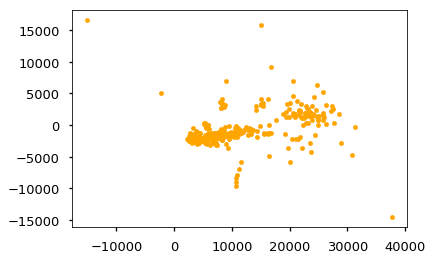

In [413]:
plt.scatter(yhat, residual, color = 'orange', s = 20)

In [874]:
usps2.count()

usps         354
shut_down    354
day          354
dtype: int64

In [922]:
endog = usps2['usps']
test = usps2['usps']
exog1 = sm.add_constant(usps2['shut_down'])
exog2 = sm.add_constant(usps2['day'])

#model = sm.tsa.statespace.SARIMAX(endog, exog1+exog2, order=(2,0,6))

In [919]:
print('endog', endog.count())
print('test', test.count())
print('exog1:', exog1.count())
#exog2.count()

endog 354
test 354
exog1: const        354
shut_down    354
dtype: int64


In [923]:
endog = endog[30:299]#.astype(float).values
test = test[253:299]#.astype(float).values
exog1 = exog1[30:299]#.astype(float).values
exog2 = exog2[30:299]#.astype(float).values

In [899]:
#usps2 = usps2[30:252]
#test = usps2[252:299]
#endog = X['usps']
#exog1 = sm.add_constant(train['shut_down'])
#exog2 = sm.add_constant(train['day'])
#X = usps2.astype(float).values #need to convert series to numpy array.
#ARIMA(df.astype(float), order=(2,0,1))
#size = int(len(X) * 0.66)
#train, test = X[30:252], X[252:299]
#test = usps2[252:299]
#endog = X['usps']
#exog1 = sm.add_constant(train['shut_down'])
#exog2 = sm.add_constant(train['day'])
history = [x for x in endog]
history2 = [y for y in exog1]
predictions = list()
for t in range(len(test)):
    model = sm.tsa.statespace.SARIMAX(history, history2, order=(2,0,6))
    model_fit = model.fit(disp=0)
    #output = model_fit.forecast()
    output = model_fit.get_prediction(dynamic='1978-01-01')
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
#error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
warnings.filterwarnings("ignore") 
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()


TypeError: 'PredictionResultsWrapper' object does not support indexing

In [925]:
mod = sm.tsa.statespace.SARIMAX(endog[30:252], exog=exog1[30:252], order=(2,0,5))
fit_res = mod.fit(disp=False)
print(fit_res.summary())

                           Statespace Model Results                           
Dep. Variable:                   usps   No. Observations:                  222
Model:               SARIMAX(2, 0, 5)   Log Likelihood               -2091.886
Date:                Tue, 13 Feb 2018   AIC                           4203.772
Time:                        10:51:28   BIC                           4237.799
Sample:                    01-21-2018   HQIC                          4217.510
                         - 01-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9925.3894   3663.786      2.709      0.007    2744.500    1.71e+04
shut_down    620.1917   3578.907      0.173      0.862   -6394.336    7634.720
ar.L1          1.8676      0.111     16.794      0.0

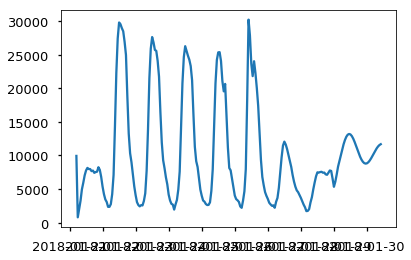

In [930]:
predict_dy = fit_res.get_prediction(dynamic='2018-01-29 00:00:00')

#output.prediction_results
#plt.plot(endog)
#plt.plot(output.prediction_results)
#plt.show()

plt.plot(predict_dy.predicted_mean)

## Create USPS train set

In [844]:
test

,usps,shut_down,day
Time,,,


In [817]:
train, test = usps2[0:90], usps2[91:178]
modelARIMAX = pf.ARIMAX(data=usps2, formula='usps~1+shut_down+day', ar = 2, integ = 0, ma = 5, family=pf.Normal())
xARX = modelARIMAX.fit("MLE")
px = modelARIMAX.predict(24, oos_data = train.iloc[-90:], intervals = True)

In [2]:
#modelARIMAX.plot_fit(figsize=(15,10), xlabel = 'Time', ylabel = 'Active Users (#)', loc = 'Best')

In [818]:
train, test = usps2[0:90], usps2[91:178]
test_clip = test[0:24]
test_clip = test_clip['usps']
px_test = px['usps']
px_test
error = mean_squared_error(test_clip, px_test)
print('Test MSE: %.3f' % error)
#warnings.filterwarnings("ignore") 
## plot
#plt.plot(test_clip)
#plt.plot(px_test, color='red')
#plt.legend()
#plt.show()

Test MSE: 85718335.216


## Second Train-Test Split

In [823]:
train, test = usps2[0:178], usps2[179:266]
modelARIMAX = pf.ARIMAX(data=train, formula='usps~1+shut_down+day', ar=2, integ = 0,  ma=5, family=pf.Normal())
xARX = modelARIMAX.fit("MLE")
px = modelARIMAX.predict(24, oos_data = train.iloc[-178:], intervals = True)

In [3]:
#modelARIMAX.plot_fit(figsize=(10,5), xlabel = 'Time', ylabel = 'Active Users (#)', loc = 'Best')

In [824]:
test_clip = test[0:24]
test_clip = test_clip['usps']
px_test = px['usps']
px_test
error = mean_squared_error(test_clip, px_test)
print('Test MSE: %.3f' % error)

Test MSE: 234512831.104


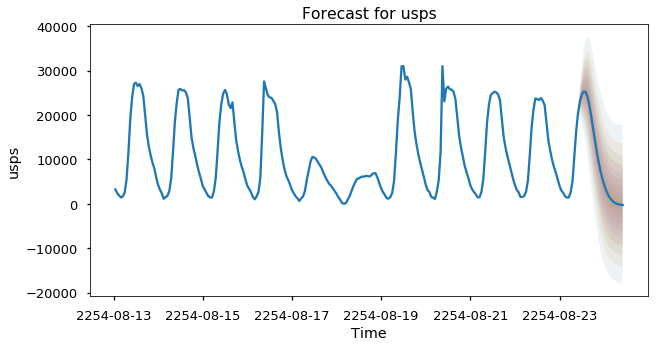

,usps,1% Prediction Interval,5% Prediction Interval,95% Prediction Interval,99% Prediction Interval
Time,,,,,
2254-08-23 11:00:00,23136.206406,18238.941562,19603.671991,26606.200149,28094.788993
2254-08-23 12:00:00,24615.090953,15169.092429,17917.028642,31150.633481,33804.203933
2254-08-23 13:00:00,25259.995293,11960.368160,15841.533341,34665.308044,38332.143929
2254-08-23 14:00:00,25222.903449,8770.202096,13661.455294,36848.560116,41343.855165
2254-08-23 15:00:00,24233.652615,5069.786143,10786.003928,37734.416782,43379.789413


In [246]:
modelARIMAX.plot_predict(h=24, oos_data = usps2.iloc[-100:], past_values=250, figsize=(10,5))
px = modelARIMAX.predict(24, oos_data = usps2.iloc[-100:], intervals = True)
px.head()

## Third Train-Test Split

In [825]:
train, test = usps2[0:266], usps2[267:354]
modelARIMAX = pf.ARIMAX(data=train, formula='usps~1+shut_down+day', ar=2, ma=6, family=pf.Normal())
xARX = modelARIMAX.fit("MLE")
px = modelARIMAX.predict(24, oos_data = train.iloc[-266:], intervals = True)

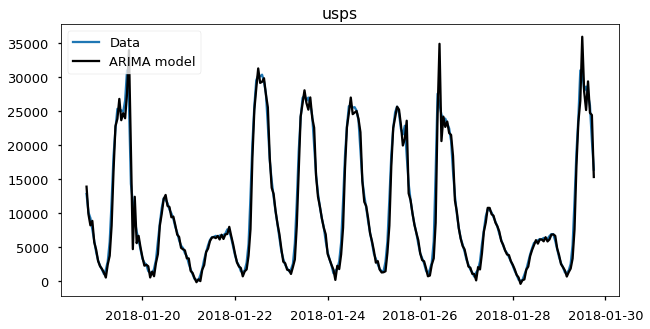

In [513]:
modelARIMAX.plot_fit(figsize=(10,5), xlabel = 'Time', ylabel = 'Active Users (#)', loc = 'Best')

In [826]:
test_clip = test[0:24]
test_clip = test_clip['usps']
px_test = px['usps']
error = mean_squared_error(test_clip, px_test)
print('Test MSE: %.3f' % error)

Test MSE: 297340499.989


# Decomposible Algorithm with expectation-maximization (EM) algorithm

In [150]:
from fbprophet import Prophet as pr

weather2 = concatenated_df[['Time', 'weather.gov/']]
weather2.head()

,Time,weather.gov/
0,2018-01-18 17:10:00,980
1,2018-01-18 17:15:00,1022
2,2018-01-18 17:20:00,1017
3,2018-01-18 17:25:00,1016
4,2018-01-18 17:31:00,986


In [151]:
weather2['weather.gov/'] = np.log(weather2['weather.gov/'])
weather2.rename(columns={'Time': 'ds','weather.gov/': 'y'}, inplace = True)
weather2.head()

,ds,y
0,2018-01-18 17:10:00,6.887553
1,2018-01-18 17:15:00,6.929517
2,2018-01-18 17:20:00,6.924612
3,2018-01-18 17:25:00,6.923629
4,2018-01-18 17:31:00,6.893656


In [147]:
## daily resolution
#m_day = pr()
#m_day.fit(weather2)

## 5-minute resolution
m_5min = pr(changepoint_prior_scale=0.01)
m_5min.fit(weather2)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [134]:
##daily resolution
#future = m.make_future_dataframe(periods=1)
#future.tail()

future_5min = m_5min.make_future_dataframe(periods=288, freq='H')
future_5min.tail()

,ds
2142,2018-02-06 05:35:00
2143,2018-02-06 06:35:00
2144,2018-02-06 07:35:00
2145,2018-02-06 08:35:00
2146,2018-02-06 09:35:00


In [135]:
##daily resolution
forecast = m.predict(future)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

##5-minute resolution
forecast_5min = m.predict(future_5min)
forecast_5min[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2142,2018-02-06 05:35:00,1.671407,-9.074551,13.143998
2143,2018-02-06 06:35:00,1.768692,-9.037628,13.295397
2144,2018-02-06 07:35:00,1.844364,-9.010830,13.439445
2145,2018-02-06 08:35:00,1.885595,-9.093405,13.533664
2146,2018-02-06 09:35:00,1.898204,-9.121476,13.627780


In [176]:
## daily resolution
#m.plot(forecast)

##5-minute resolution
#m_5min.plot(forecast_5min)

In [167]:
weather3 = weather.loc[weather['Time'] <= '2018-01-25 00:00:00']
weather3 = weather3[['Time', 'weather']]
weather3.rename(columns={'Time': 'ds','weather.gov/': 'y'}, inplace = True)
weather3.tail()

,ds,y
Time,,
2018-01-24 23:40:00,2018-01-24 23:40:00,454
2018-01-24 23:45:00,2018-01-24 23:45:00,424
2018-01-24 23:50:00,2018-01-24 23:50:00,401
2018-01-24 23:55:00,2018-01-24 23:55:00,374
2018-01-25 00:00:00,2018-01-25 00:00:00,449


In [198]:
#m = pr(changepoint_prior_scale=0.001, mcmc_samples=300)
#forecast = m.fit(weather2).predict(future)
m.plot(forecast, xlabel = 'Time (days)', ylabel = 'Log Active Users')

SyntaxError: invalid syntax (<ipython-input-198-cddea487ec3f>, line 3)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


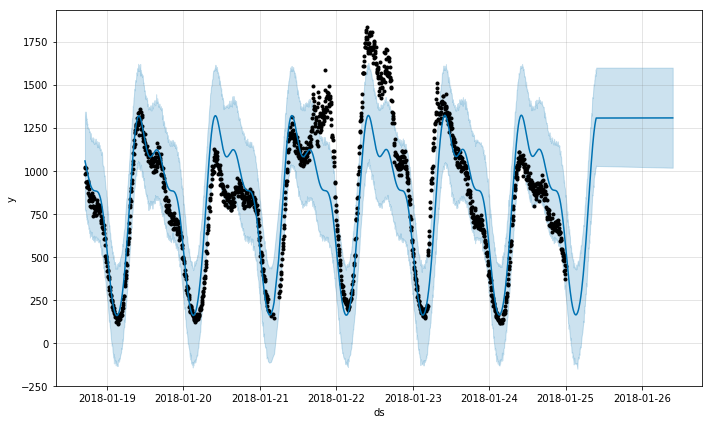

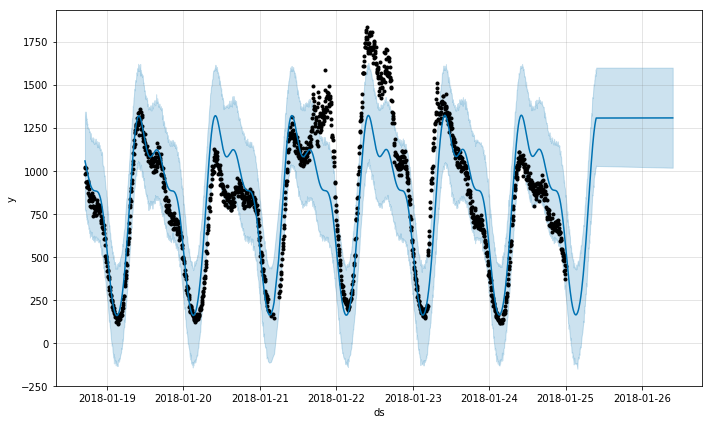

In [168]:
m = pr(changepoint_prior_scale=0.001)
forecast = m.fit(weather3).predict(future)
m.plot(forecast)

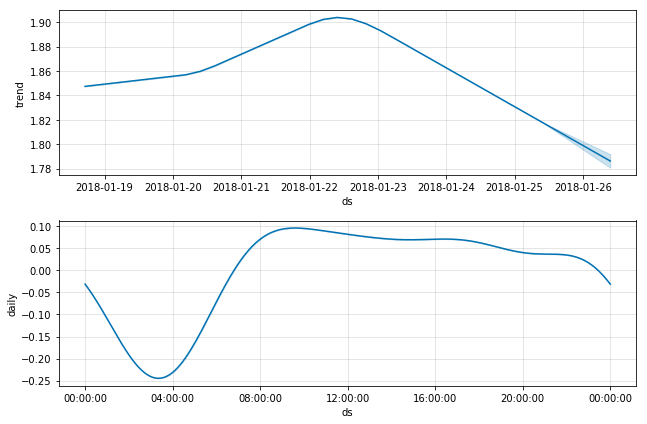

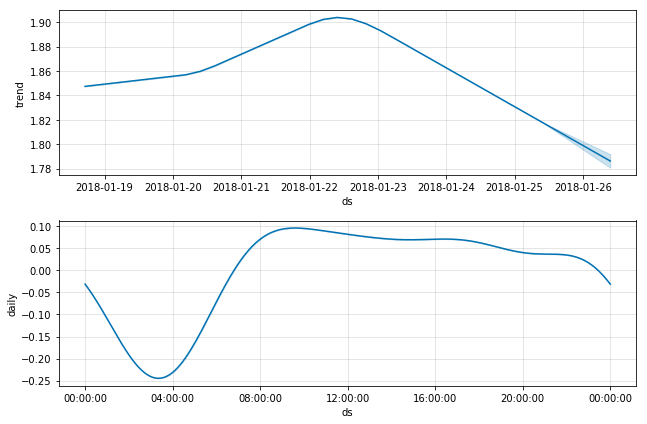

In [139]:
m.plot_components(forecast)

# DFA to assess self-similarity

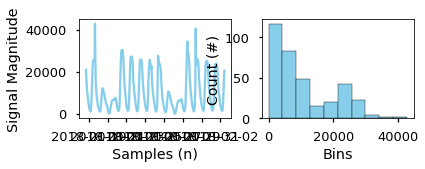

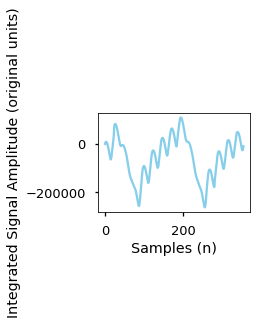

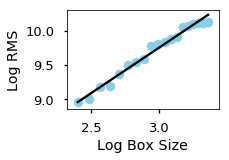

fractal_index:  1.32


In [520]:
from dfa import dfa
signal = agg_df['usps.com/']
box_min = 3
box_max = 30

dfa(signal, box_min, box_max)

# LSTM MODEL

In [128]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from numpy import log

In [129]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [70]:
usps2.head()

,usps,shut_down,nasalognorm
Time,,,
2018-01-18 17:00:00,20860,0.0,9.945589
2018-01-18 18:00:00,16905,0.0,9.735365
2018-01-18 19:00:00,12792,0.0,9.456575
2018-01-18 20:00:00,10086,0.0,9.218904
2018-01-18 21:00:00,9249,0.0,9.132271


In [437]:
#agg_df = concatenated_df.set_index('Time')
#agg_df = agg_df.resample("H").sum()

nn_weather = df.filter(['usps'], axis = 1)
#nn_weather.rename(columns={'usps.com/': 'usps'}, inplace = True)
#nn_weather2 = nn_weather
#data = usps2.filter(['usps', 'shut_down'], axis = 1)
#nn_weather.tail()
nn_weather.head()

,usps
Time,
2018-01-18 17:00:00,20860
2018-01-18 18:00:00,16905
2018-01-18 19:00:00,12792
2018-01-18 20:00:00,10086
2018-01-18 21:00:00,9249


### Split series into training and test set to check the variance

In [65]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(agg_df['usps.com/'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
if result[1] > 0.05:
    print('Time-series is non-stationary and the process HAS A unit-rott')
else:
    print('Time-series is stationary and the process HAS NO unit-root')

ADF Statistic: -8.278743
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
Time-series is stationary and the process HAS NO unit-root


In [337]:
#nn_weather = nn_weather.values
nn_weather = nn_weather.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
nn_weather = scaler.fit_transform(nn_weather)

In [386]:

# split into train and test sets
#train, test = X[0:90], X[90:178]
#train_size = int(len(nn_weather) * 0.67)
#test_size = len(nn_weather) - train_size
#train, test = nn_weather[0:train_size,:], nn_weather[train_size:len(nn_weather),:]

train, test = nn_weather[0:90,:], nn_weather[90:178,:]
print(len(train), len(test))

90 88


In [387]:
def create_dataset(nn_weather, look_back=1):
    dataX, dataY = [], []
    for i in range(len(nn_weather)-look_back-1):
        a = nn_weather[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(nn_weather[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [346]:
# create and fit the LSTM network
look_back = 1
dataX, dataY = create_dataset(train, look_back)

# reshape input to be [samples, time steps, features]
dataX = np.reshape(dataX, (dataX.shape[0], 1, dataX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) 
model.add(Dense(1)) #output layer
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history = model.fit(dataX, dataY, epochs=100, batch_size=1, verbose=1) #, validation_split = 0.33)

Epoch 1/100
235/235 [==============================] - 4s 17ms/step - loss: 0.0374 - acc: 0.0043
Epoch 2/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0187 - acc: 0.0085
Epoch 3/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0119 - acc: 0.0085
Epoch 4/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0084 - acc: 0.0085
Epoch 5/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0073 - acc: 0.0085
Epoch 6/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0071 - acc: 0.0085
Epoch 7/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0071 - acc: 0.0085
Epoch 8/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0071 - acc: 0.0085
Epoch 9/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0070 - acc: 0.0085
Epoch 10/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0070 - acc: 0.0085
Epoch 11/100
235/235 [================

In [369]:
# create and fit the LSTM network
look_back = 1
dataX, dataY = create_dataset(train, look_back)

# reshape input to be [samples, time steps, features]
dataX = np.reshape(dataX, (dataX.shape[0], 1, dataX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) 
model.add(Dense(1)) #output layer
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history = model.fit(dataX, dataY, epochs=12, batch_size=1, verbose=1) #, validation_split = 0.33)

Epoch 1/12
235/235 [==============================] - 4s 18ms/step - loss: 0.1039 - acc: 0.0043
Epoch 2/12
235/235 [==============================] - 2s 7ms/step - loss: 0.0563 - acc: 0.0043
Epoch 3/12
235/235 [==============================] - 2s 7ms/step - loss: 0.0420 - acc: 0.0043
Epoch 4/12
235/235 [==============================] - 2s 7ms/step - loss: 0.0297 - acc: 0.0085
Epoch 5/12
235/235 [==============================] - 2s 7ms/step - loss: 0.0189 - acc: 0.0085
Epoch 6/12
235/235 [==============================] - 2s 7ms/step - loss: 0.0116 - acc: 0.0085
Epoch 7/12
235/235 [==============================] - 2s 7ms/step - loss: 0.0083 - acc: 0.0085
Epoch 8/12
235/235 [==============================] - 2s 8ms/step - loss: 0.0071 - acc: 0.0085
Epoch 9/12
235/235 [==============================] - 2s 8ms/step - loss: 0.0072 - acc: 0.0085
Epoch 10/12
235/235 [==============================] - 2s 7ms/step - loss: 0.0070 - acc: 0.0085
Epoch 11/12
235/235 [===========================

In [388]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [389]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [390]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) 
model.add(Dense(1)) #output layer
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1, validation_split = 0.33)

Train on 58 samples, validate on 30 samples
Epoch 1/20
58/58 [==============================] - 4s 65ms/step - loss: 0.1378 - acc: 0.0000e+00 - val_loss: 0.0280 - val_acc: 0.0000e+00
Epoch 2/20
58/58 [==============================] - 0s 8ms/step - loss: 0.1058 - acc: 0.0000e+00 - val_loss: 0.0189 - val_acc: 0.0000e+00
Epoch 3/20
58/58 [==============================] - 0s 8ms/step - loss: 0.0851 - acc: 0.0000e+00 - val_loss: 0.0155 - val_acc: 0.0000e+00
Epoch 4/20
58/58 [==============================] - 0s 8ms/step - loss: 0.0718 - acc: 0.0000e+00 - val_loss: 0.0156 - val_acc: 0.0000e+00
Epoch 5/20
58/58 [==============================] - 1s 9ms/step - loss: 0.0636 - acc: 0.0000e+00 - val_loss: 0.0176 - val_acc: 0.0000e+00
Epoch 6/20
58/58 [==============================] - 0s 8ms/step - loss: 0.0580 - acc: 0.0000e+00 - val_loss: 0.0187 - val_acc: 0.0000e+00
Epoch 7/20
58/58 [==============================] - 1s 9ms/step - loss: 0.0542 - acc: 0.0000e+00 - val_loss: 0.0207 - val_acc: 

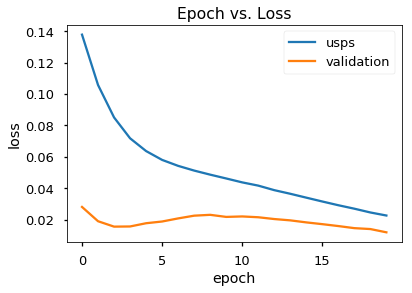

In [392]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Epoch vs. Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['usps', 'validation'], loc='upper right')
plt.show()

In [393]:
# full data set
trainPredict = model.predict(dataX)
trainPredict = scaler.inverse_transform(trainPredict)
dataY = scaler.inverse_transform([dataY])
trainScore = math.sqrt(mean_squared_error(dataY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

ValueError: Found array with dim 3. Estimator expected <= 2.

In [373]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(nn_weather)
trainPredictPlot[:, :] = np.nan
#trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

trainPredictPlot[len(trainPredict)+(look_back*2)+1:len(nn_weather)-1, :] = trainPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(nn_weather))
plt.plot(trainPredictPlot)
#plt.plot(testPredictPlot)
plt.tick_params(labelsize=12)
plt.xlabel('Sample (#)', fontsize = 20)
plt.ylabel('Active Users (#)', fontsize = 20)
plt.legend()
plt.show()

ValueError: could not broadcast input array from shape (235,1) into shape (352,1)

In [394]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.13 RMSE
Test Score: 0.18 RMSE


In [395]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(nn_weather)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(nn_weather)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(nn_weather)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(nn_weather))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.tick_params(labelsize=12)
plt.xlabel('Sample (#)', fontsize = 20)
plt.ylabel('Active Users (#)', fontsize = 20)
plt.legend()
plt.show()

ValueError: could not broadcast input array from shape (86,1) into shape (262,1)

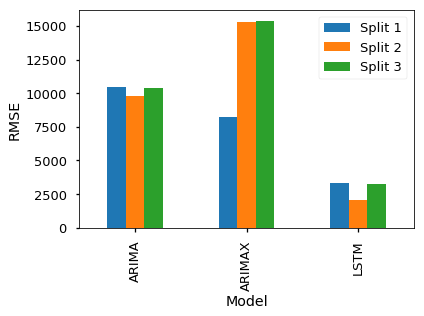

In [549]:
from matplotlib.pyplot import *
X = ['ARIMA','ARIMAX','LSTM']
J = [10477, 8211, 3338]
K = [9778,15255,2083]
L = [10383,15395,3242]



df = pd.DataFrame(np.c_[J,K,L], index=X)
df.plot.bar()
plt.xlabel('Model')
plt.ylabel('RMSE')
legend(['Split 1', 'Split 2', 'Split 3'])
plt.show()

In [39]:
from numpy import array
data = array([0.1, 0.2, 0.3]).reshape((1,3,1))
print(data)

[[[ 0.1]
  [ 0.2]
  [ 0.3]]]


Epoch 1/100
 - 6s - loss: 0.1165 - mean_squared_error: 0.1165
Epoch 2/100
 - 1s - loss: 0.0835 - mean_squared_error: 0.0835
Epoch 3/100
 - 1s - loss: 0.0674 - mean_squared_error: 0.0674
Epoch 4/100
 - 1s - loss: 0.0595 - mean_squared_error: 0.0595
Epoch 5/100
 - 1s - loss: 0.0559 - mean_squared_error: 0.0559
Epoch 6/100
 - 1s - loss: 0.0533 - mean_squared_error: 0.0533
Epoch 7/100
 - 1s - loss: 0.0513 - mean_squared_error: 0.0513
Epoch 8/100
 - 1s - loss: 0.0495 - mean_squared_error: 0.0495
Epoch 9/100
 - 1s - loss: 0.0477 - mean_squared_error: 0.0477
Epoch 10/100
 - 1s - loss: 0.0458 - mean_squared_error: 0.0458
Epoch 11/100
 - 1s - loss: 0.0438 - mean_squared_error: 0.0438
Epoch 12/100
 - 1s - loss: 0.0419 - mean_squared_error: 0.0419
Epoch 13/100
 - 1s - loss: 0.0396 - mean_squared_error: 0.0396
Epoch 14/100
 - 1s - loss: 0.0373 - mean_squared_error: 0.0373
Epoch 15/100
 - 1s - loss: 0.0351 - mean_squared_error: 0.0351
Epoch 16/100
 - 1s - loss: 0.0327 - mean_squared_error: 0.0327
E

Epoch 32/100
 - 1s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 33/100
 - 1s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 34/100
 - 1s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 35/100
 - 1s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 36/100
 - 1s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 37/100
 - 1s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 38/100
 - 1s - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 39/100
 - 1s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 40/100
 - 1s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 41/100
 - 1s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 42/100
 - 1s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 43/100
 - 1s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 44/100
 - 2s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 45/100
 - 1s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 46/100
 - 2s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 47/100
 - 2s - loss: 0.0073 - mean_squared_error:

KeyboardInterrupt: 

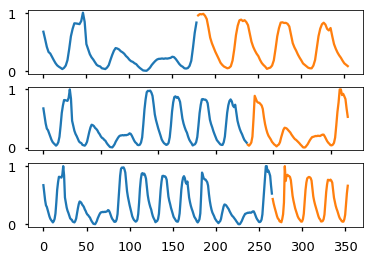

In [450]:
from pandas import Series
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot as plt

#X = nn_weather.values
#X = nn_weather.astype('float32')
X = nn_weather
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

splits = TimeSeriesSplit(n_splits=3)
plt.figure(1)
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    plt.subplot(310 + index)
    plt.plot(train)
    #plt.plot(history.history['mean_squared_error'])
    plt.plot([None for i in train] + [x for x in test])
    
    def create_dataset(nn_weather, look_back=1):
        dataX, dataY = [], []
        for i in range(len(nn_weather)-look_back-1):
            a = X[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(X[i + look_back, 0])
        return np.array(dataX), np.array(dataY)
    
    # reshape into X=t and Y=t+1
    look_back = 1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(3, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
    
    index += 1
plt.show()

KeyError: 'val_loss'

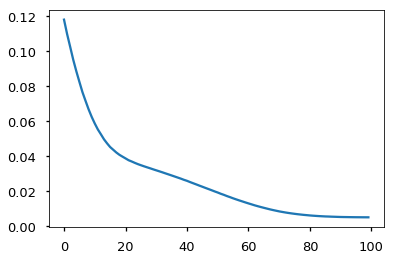

In [154]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## LSTM multivariate version

In [558]:
from pandas import concat
# date-time parsing function for loading the dataset

#def parser(x):
#    return datetime.strptime('190'+x, '%Y-%m')
df = nn_weather
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# create a differenced series
#def difference(dataset, interval=1):
#    diff = list()
#    for i in range(interval, len(dataset)):
#        value = dataset[i] - dataset[i - interval]
#        diff.append(value)
#    return Series(diff)
 
# invert differenced value
#def inverse_difference(history, yhat, interval=1):
#    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
#def scale(train, test):
#    # fit scaler
#    scaler = MinMaxScaler(feature_range=(-1, 1))
#    scaler = scaler.fit(train)
#    # transform train
#    train = train.reshape(train.shape[0], train.shape[1])
#    train_scaled = scaler.transform(train)
#    # transform test
#    test = test.reshape(test.shape[0], test.shape[1])
#    test_scaled = scaler.transform(test)
#    return scaler, train_scaled, test_scaled

def scale(full):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(full)
    # transform full
    full = full.reshape(full.shape[0], full.shape[1])
    full_scaled = scaler.transform(full)
    return scaler, full_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
#def fit_lstm(train, batch_size, nb_epoch, neurons):
#    X, y = train[:, 0:-1], train[:, -1]
#    X = X.reshape(X.shape[0], 1, X.shape[1])
#    model = Sequential()
#    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
#    model.add(Dense(1))
#    model.compile(loss='mean_squared_error', optimizer='adam')
#    for i in range(nb_epoch):
#        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
#        model.reset_states()
#    return model

def fit_lstm(full, batch_size, nb_epoch, neurons):
    X = full[:, 0:-1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
 
# load dataset
#series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
 
# transform data to be stationary
#raw_values = series.values
#diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
#supervised = timeseries_to_supervised(nn_weather, 1) # original line
supervised = timeseries_to_supervised(nn_weather, 1)
print(supervised.head())
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:90], supervised_values[90:178]# first split
#train, test = supervised_values[0:-12], supervised_values[-12:]
full = supervised_values

# transform the scale of the data
#scaler, train_scaled, test_scaled = scale(train, test)
scaler, full_scaled = scale(full)
 
# fit the model
#lstm_model = fit_lstm(train_scaled, 1, 100, 3)
# forecast the entire training dataset to build up state for forecasting
#train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
#lstm_model.predict(train_reshaped, batch_size=1)

lstm_model = fit_lstm(full_scaled, 1, 100, 3)
# forecast the entire training dataset to build up state for forecasting
full_reshaped = full_scaled[:, 0].reshape(len(full_scaled), 1, 1)
lstm_model.predict(full_reshaped, batch_size=1)
 
# walk-forward validation on the test data
#predictions = list()
#for i in range(len(test_scaled)):
#    # make one-step forecast
#    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
#    yhat = forecast_lstm(lstm_model, 1, X)
#    # invert scaling
#    yhat = invert_scale(scaler, X, yhat)
#    # invert differencing
##    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
#    # store forecast
#    predictions.append(yhat)
#    #expected = raw_values[len(train) + i + 1] # original line
#    #expected = nn_weather[len(train) + i + 1]
#    #print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 
## report performance
# mse = mean_squared_error(raw_values[-12:], predictions) #original line with raw_values
#mse = mean_squared_error(nn_weather[90:178], predictions)
#print('Test MSE: %.3f' % mse)
# line plot of observed vs predicted
#plt.plot(raw_values[90:178]) #original line for stationarity 
#plt.plot(test)
#plt.plot(predictions)
plt.plot(full_scaled)
plt.plot(nn_weather)
plt.legend()
plt.show()

                        usps  shut_down   usps  shut_down
Time                                                     
2018-01-18 17:00:00      0.0        0.0  20860        0.0
2018-01-18 18:00:00  20860.0        0.0  16905        0.0
2018-01-18 19:00:00  16905.0        0.0  12792        0.0
2018-01-18 20:00:00  12792.0        0.0  10086        0.0
2018-01-18 21:00:00  10086.0        0.0   9249        0.0


NameError: name 'full_scled' is not defined

                        usps   usps
Time                               
2018-01-18 17:00:00      0.0  20860
2018-01-18 18:00:00  20860.0  16905
2018-01-18 19:00:00  16905.0  12792
2018-01-18 20:00:00  12792.0  10086
2018-01-18 21:00:00  10086.0   9249
Test MSE: 4340067.127


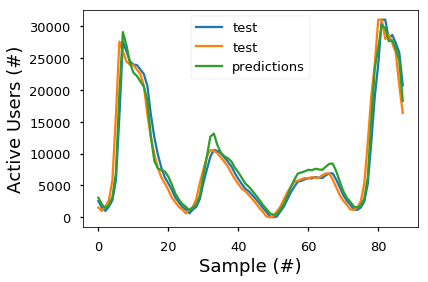

In [456]:
train, test = X[0:178], X[178:266]


from pandas import concat
# date-time parsing function for loading the dataset

#def parser(x):
#    return datetime.strptime('190'+x, '%Y-%m')
df = nn_weather
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# create a differenced series
#def difference(dataset, interval=1):
#    diff = list()
#    for i in range(interval, len(dataset)):
#        value = dataset[i] - dataset[i - interval]
#        diff.append(value)
#    return Series(diff)
 
# invert differenced value
#def inverse_difference(history, yhat, interval=1):
#    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
 
# load dataset
#series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
 
# transform data to be stationary
#raw_values = series.values
#diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
#supervised = timeseries_to_supervised(nn_weather, 1) # original line
supervised = timeseries_to_supervised(nn_weather, 1)
print(supervised.head())
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:178], supervised_values[178:266]# first split
#train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 100, 3)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
#    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    #expected = raw_values[len(train) + i + 1] # original line
    #expected = nn_weather[len(train) + i + 1]
    #print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

## report performance
# mse = mean_squared_error(raw_values[-12:], predictions) #original line with raw_values
mse = mean_squared_error(nn_weather[178:266], predictions)
print('Test MSE: %.3f' % mse)
# line plot of observed vs predicted
#plt.plot(raw_values[90:178]) #original line for stationarity 
plt.plot(test, label = 'test')
plt.xlabel('Sample (#)', fontsize=18)
plt.ylabel('Active Users (#)', fontsize=18)
plt.plot(predictions, label = 'predictions')
plt.legend(loc = 'best')
plt.show()

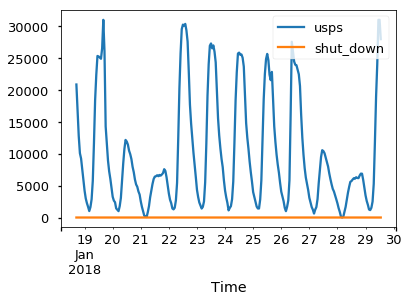

In [566]:
nn_test = nn_weather[0:258]
nn_test.plot()

In [677]:
nn_weather = uspsdf.filter(['usps'], axis = 1)
nn_weather.head()

,usps
Time,
2018-01-18 17:00:00,20860
2018-01-18 18:00:00,16905
2018-01-18 19:00:00,12792
2018-01-18 20:00:00,10086
2018-01-18 21:00:00,9249


In [722]:
from pandas import concat
# date-time parsing function for loading the dataset

#def parser(x):
#    return datetime.strptime('190'+x, '%Y-%m')
#df = nn_weather
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# create a differenced series
#def difference(dataset, interval=1):
#    diff = list()
#    for i in range(interval, len(dataset)):
#        value = dataset[i] - dataset[i - interval]
#        diff.append(value)
#    return Series(diff)
 
# invert differenced value
#def inverse_difference(history, yhat, interval=1):
#    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
 
# load dataset
#series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
 
# transform data to be stationary
#raw_values = series.values
#diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
#supervised = timeseries_to_supervised(nn_weather, 1) # original line
supervised = timeseries_to_supervised(nn_weather, 1)
print(supervised.head())
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[30:252], supervised_values[253:299]# first split
#train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 100, 3)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    # yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    #expected = raw_values[len(train) + i + 1] # original line
    #expected = nn_weather[len(train) + i + 1]
    #print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

## report performance
# mse = mean_squared_error(raw_values[-12:], predictions) #original line with raw_values
mse = mean_squared_error(nn_weather[253:299], predictions)
print('Test MSE: %.3f' % mse)
# line plot of observed vs predicted
#plt.plot(raw_values[90:178]) #original line for stationarity change slice
#plt.plot(test, label = 'test', color = 'blue')
#plt.xlabel('Sample (#)', fontsize=18)
#plt.ylabel('Active Users (#)', fontsize=18)
#plt.plot(predictions, label = 'predictions', color = 'red')
#plt.legend(loc = 'best')
#plt.show()

                        usps   usps
Time                               
2018-01-18 17:00:00      0.0  20860
2018-01-18 18:00:00  20860.0  16905
2018-01-18 19:00:00  16905.0  12792
2018-01-18 20:00:00  12792.0  10086
2018-01-18 21:00:00  10086.0   9249
Test MSE: 28291375.756


In [743]:
raw = nn_weather[30:252]
model = lstm_model.predict(train_reshaped, batch_size=1)
modelyhat = invert_scale(scaler, X, model)
resi_mod = raw-model

modelyhat

ValueError: setting an array element with a sequence.

In [733]:
raw = nn_weather[30:252]
model = lstm_model.predict(train_reshaped, batch_size=1)

plt.plot(raw, label = 'Raw Test data', color = 'blue')
plt.xlabel('Sample (#)', fontsize=18)
plt.ylabel('Active Users (#)', fontsize=18)
plt.plot(model, label = 'model', color = 'red')
plt.plot(resi_mod, label = 'residuals', color = 'green')
plt.legend(loc = 'best')
plt.show()

ValueError: ordinal must be >= 1

In [723]:
a = [row[0] for row in test]
y = pd.DataFrame(a)
yhat = pd.DataFrame(predictions)
residual = y - yhat

#RMSE
rmseLSTM = ((y - yhat) ** 2).mean() ** .5
rmseLSTM.astype(float)
#print("RMSE of ARIMA (%p, %q, %d)" %(p, q, d))
print('RMSE of LSTM:', rmseARIMAX)

RMSE of LSTM: 0    2241.578186
dtype: float64


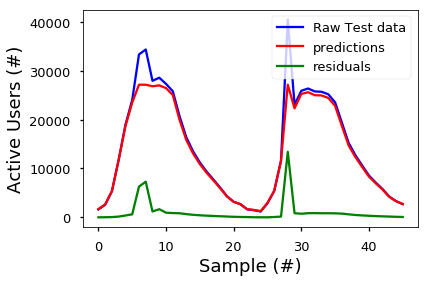

In [726]:
pd.DataFrame(test)
plt.plot(a, label = 'Raw Test data', color = 'blue')
plt.xlabel('Sample (#)', fontsize=18)
plt.ylabel('Active Users (#)', fontsize=18)
plt.plot(predictions, label = 'predictions', color = 'red')
plt.plot(residual, label = 'residuals', color = 'green')
plt.legend(loc = 'best')
plt.show()

## Sliding Window

In [ ]:
def window(iterable, size=2):
    i = iter(iterable)
    win = []
    for e in range(0, size):
        win.append(next(i))
    yield win
    for e in i:
        win = win[1:] + [e]
        yield win

## DFA

In [517]:
signal = nn_weather

integ_sig = np.array([0]) #Create a numpy array to append results
i = 1 # Set a counter
cur_int = 0 
p = signal.shape[0] # get length of singal input
    
while i < p + 1:
    cur_int = signal[i] - np.mean(signal) #zero-base the signal
    integ_sig = np.append(integ_sig, integ_sig[i-1] + cur_int) # rectangle method 
    i = i + 1
    if i == p: # Avoid infinite while loop. 
        break
        
    
ni = integ_sig.shape[0]
    
## Calculate RMS for each box size ##
    
log_b = np.array([0])
log_r = np.array([0]) 
    

for box_size in range (box_min, box_max):
    j = np.floor_divide(ni,box_size) # set number of points per box.
    r = np.array([0])
        
    for i in range(0,j+1):
        z = np.arange(((box_size * i) - box_size), (box_size * i))
        seg = integ_sig[z]
            
        ## Calculate LOBF and RMS for each segment.
        rms = 0
        slope_num = 0
        slope_den = 0
        seg_pred = np.array([0])
            
        for k in range(0,box_size):
            slope_num = slope_num + ((z[k] - np.mean(z)) * (seg[k] - np.mean(z)))
            slope_den = slope_den + ((z[k] - np.mean(z))**2)
        np.seterr(divide='ignore', invalid='ignore')
        slope = slope_num / slope_den
        intercept = np.mean(seg) - (slope * np.mean(z))
            
        for l in range (0,box_size):
            seg_pred = np.append(seg_pred, intercept + (slope * z[l]))
        seg_pred = seg_pred[1:,]
            
        # Detrend the segmet of interest
        for m in range (0,box_size):
            rms = rms + ((seg[m] - seg_pred[m])**2)
            
        # calculate the root-mean square
        rms = rms / box_size
        rms = rms**0.5
        r = np.append(r, rms)
        
    #r = r[1:,]
    r = np.mean(r)
    log_b = np.append(log_b, np.log(box_size))
    log_r = np.append(log_r, np.log(r))
        
log_b = log_b[9:,]
log_r = log_r[9:,]
    
p = np.polyfit(log_b, log_r, 1)
plt.scatter(log_b, log_r, color = 'skyblue')
plt.plot(np.unique(log_b), np.poly1d(np.polyfit(log_b, log_r, 1))(np.unique(log_b)), color = 'black')
plt.xlabel('Log Box Size')
plt.ylabel('Log RMS')
plt.show()
    
fractindex = np.round_(p[0], 2)

KeyError: 1